## Plot zonal-mean zonal wind speed

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import subplot_label_generator

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_results
from util_plot_func import MidpointNormalize, use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
# Parameters
metallicity = "solar"
t0 = 80  # 80th slice of 10-day-frequency output, i.e. 800 day
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels

In [6]:
vrbls = {}
for planet in PLANETS.keys():
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        # Find data
        fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
        fname = f"{SUITES[planet][exp][metallicity]['suite']}.nc"
        # Load variables
        u = iris.load_cube(str(fpath / fname), um.u)[t0:, ...]
        pres = iris.load_cube(str(fpath / fname), um.pres)[-1, ...]
        lats_coord = u.coord("latitude")
        # Interpolate u wind speed to pressure levels
        u_plevs = interp_cube_from_height_to_pressure_levels(u, pres, tgt_plevs)
        pres_coord = u_plevs.coord("air_pressure")
        # Calculate zonal-mean zonal wind speed
        u_plevs_znl_mean = u_plevs.collapsed(["time", "longitude"], iris.analysis.MEAN)
        u_plevs_znl_mean.convert_units("km s-1")
        # Find max zonal-mean zonal wind speed location
        max_u_z, max_u_y = np.where(u_plevs_znl_mean.data == u_plevs_znl_mean.data.max())
        # Assemble data
        vrbls[planet][exp] = {
            "u_plevs_znl_mean": u_plevs_znl_mean,
            "max_u_z": max_u_z,
            "max_u_y": max_u_y,
        }

In [7]:
# Print max zonal-mean zonal (superrotating) wind speed
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        print(planet, exp[0:3], vrbls[planet][exp]["u_plevs_znl_mean"].data[vrbls[planet][exp]["u_plevs_znl_mean"].data>0].max())

hatp11b equ 2.5630514241145166
hatp11b kin 2.37745555184298
hd189733b equ 6.384280900577803
hd189733b kin 6.4925952695087545
hd209458b equ 6.121897856514839
hd209458b kin 6.115538297699676
wasp17b equ 6.555324347217663
wasp17b kin 6.554799245581394


In [9]:
# Print max zonal-mean zonal (retrograge) wind speed
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        print(planet, exp[0:3], vrbls[planet][exp]["u_plevs_znl_mean"].data[vrbls[planet][exp]["u_plevs_znl_mean"].data<0].min())

hatp11b equ -0.3298512407360632
hatp11b kin -0.6176216262324257
hd189733b equ -1.4772708287842915
hd189733b kin -1.5055010798442514
hd209458b equ -0.8179745960432697
hd209458b kin -0.8282424197019381
wasp17b equ -1.4964405293768375
wasp17b kin -1.4965671552048234


In [11]:
# Plotting parameters
# Normalise colormap around zero based on max u_plevs_znl_mean across four planets
midnorm = MidpointNormalize(vmin=-7, vcenter=0, vmax=7)

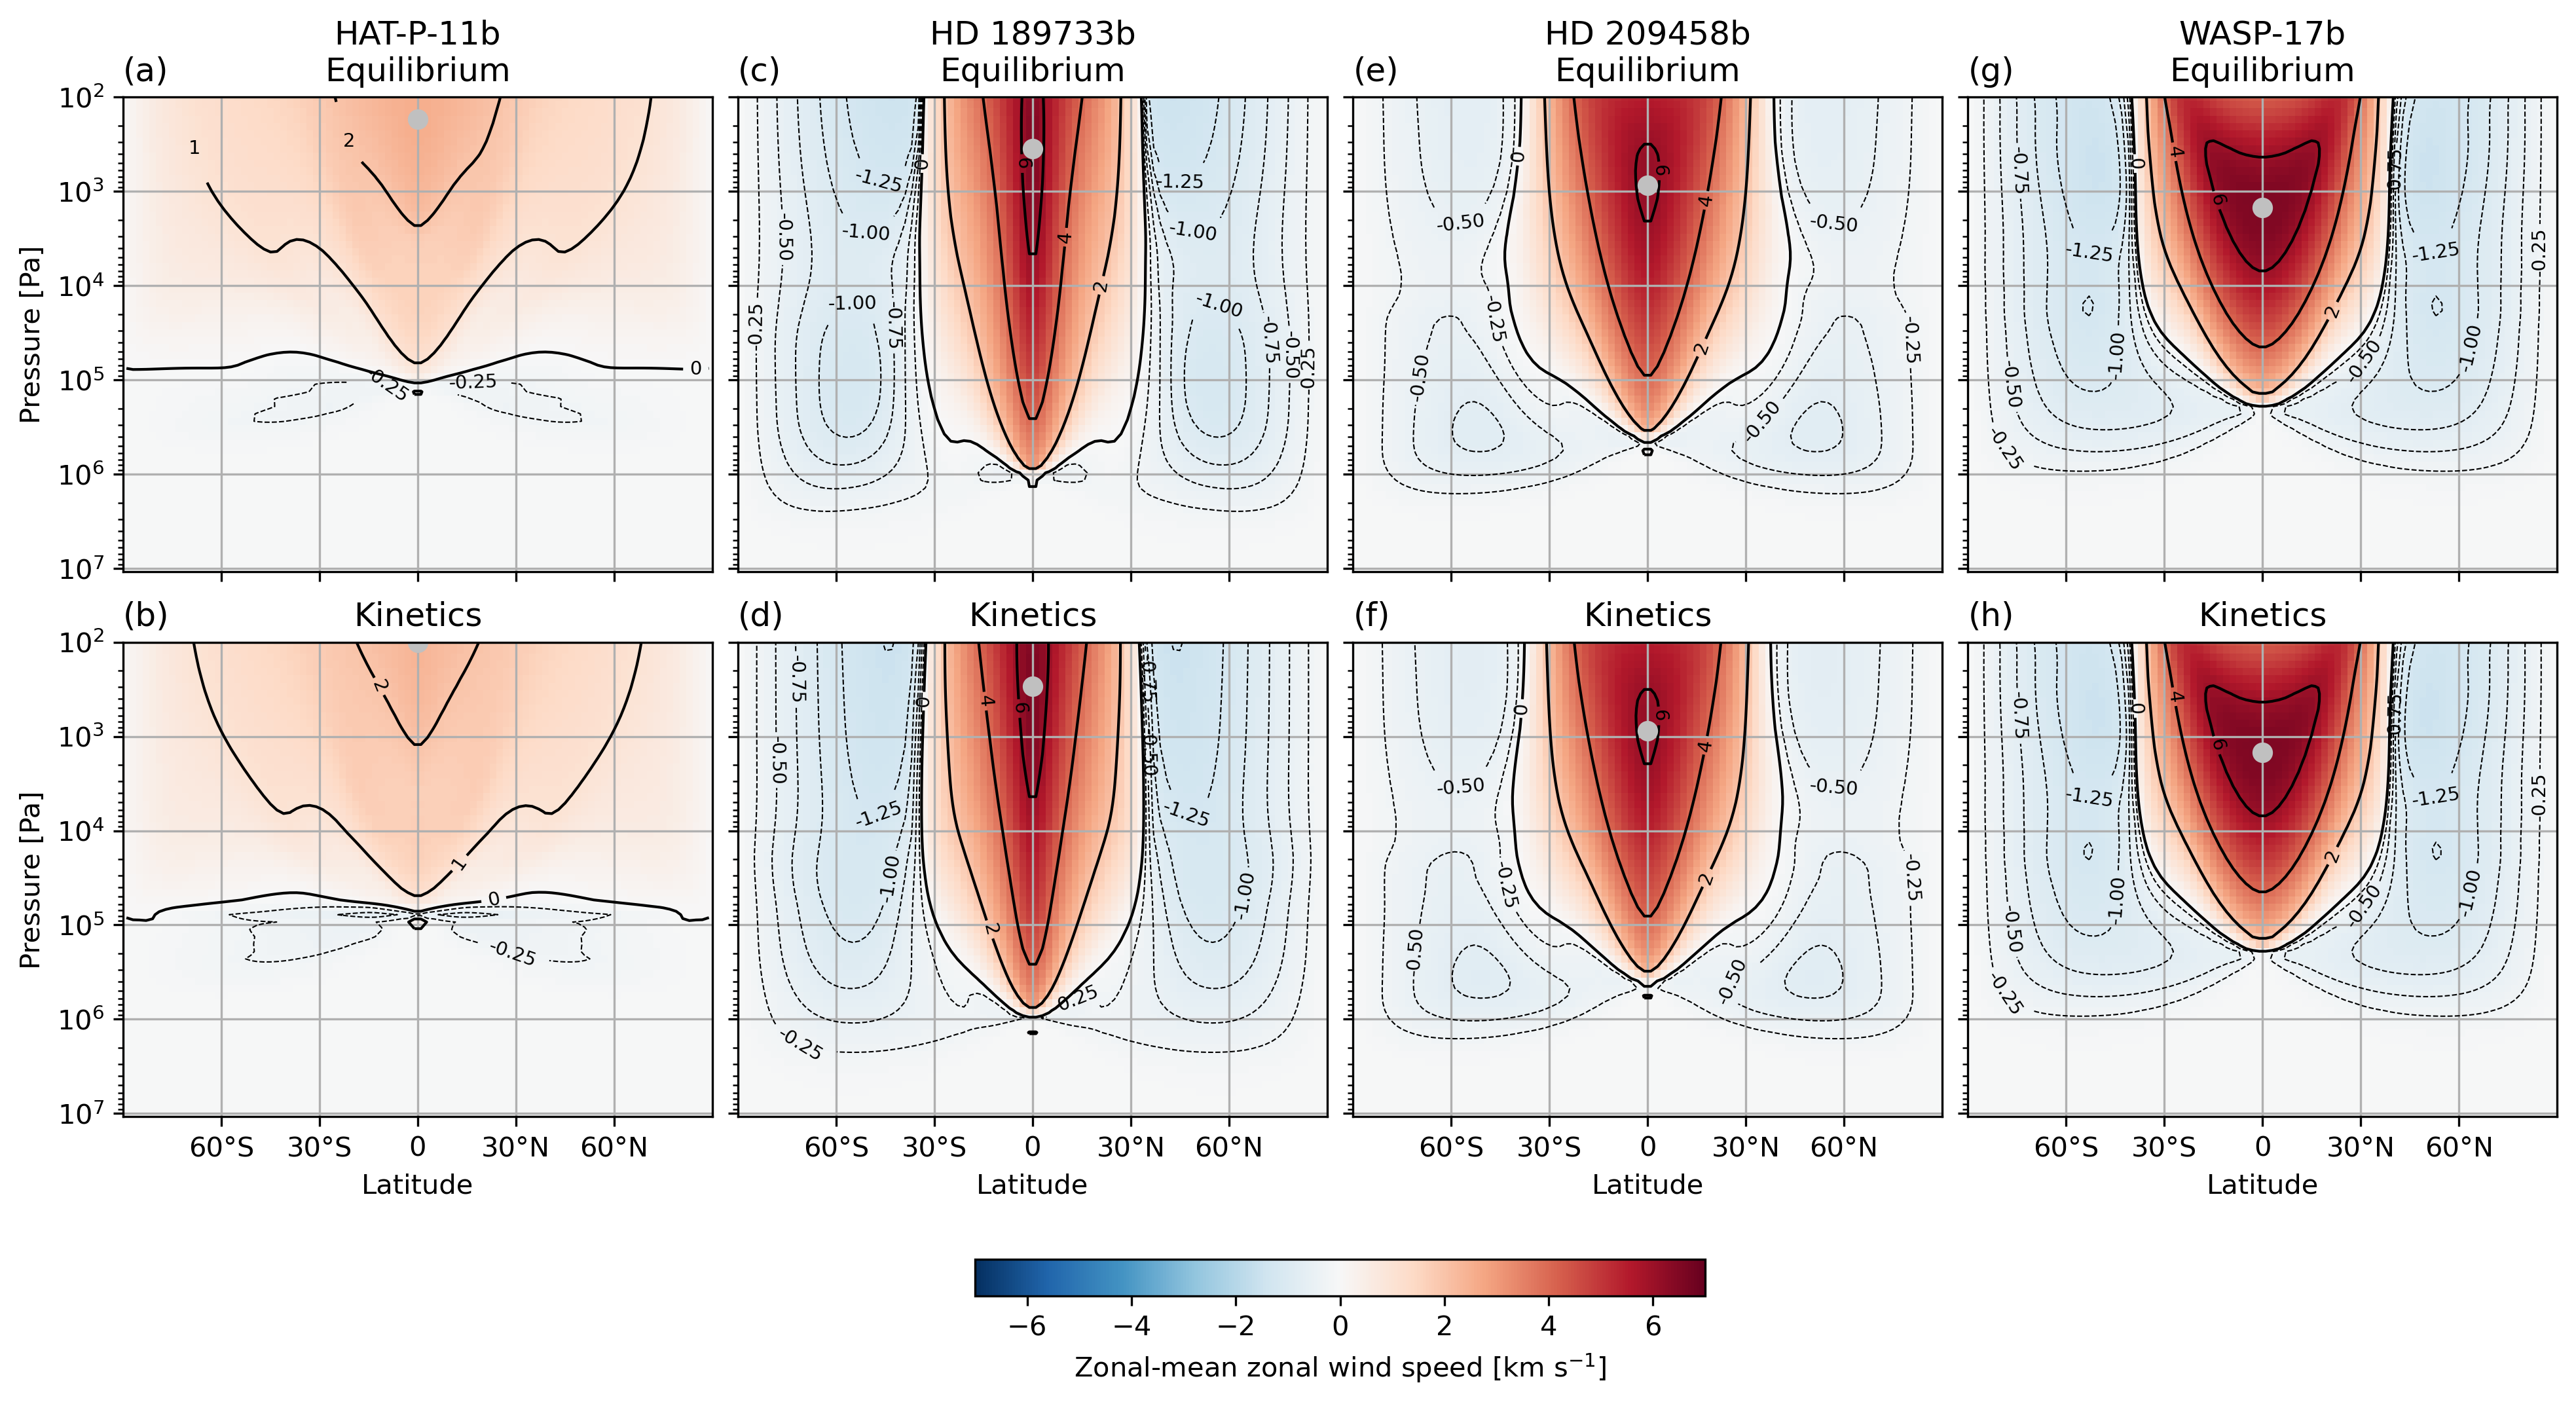

In [12]:
# Plot
fig, axes = plt.subplots(
    ncols=4,
    nrows=2,
    figsize=(13, 7),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
axes[0, 0].invert_yaxis()
iletters = subplot_label_generator()
for planet, axcol in zip(PLANETS.keys(), axes.T):
    for exp, ax in zip(["equilibrium", "kinetics"], axcol):
        u_plevs_znl_mean = vrbls[planet][exp]["u_plevs_znl_mean"]
        max_u_y = vrbls[planet][exp]["max_u_y"][0]
        max_u_z = vrbls[planet][exp]["max_u_z"][0]
        p0 = ax.pcolormesh(
            lats_coord.points,
            pres_coord.points,
            u_plevs_znl_mean.data,
            norm=midnorm,
            cmap="RdBu_r",
            shading="auto",
            rasterized=True,
        )
        # Add contours
        if ax.get_subplotspec().is_first_col():
            p1 = ax.contour(
                lats_coord.points,
                pres_coord.points,
                u_plevs_znl_mean.data,
                levels=np.arange(-2, 8, 1),
                colors="k",
                linewidths=1,
            )
        else:
            p1 = ax.contour(
                lats_coord.points,
                pres_coord.points,
                u_plevs_znl_mean.data,
                levels=np.arange(-2, 8, 2),
                colors="k",
                linewidths=1,
            )
        p2 = ax.contour(
            lats_coord.points,
            pres_coord.points,
            u_plevs_znl_mean.data,
            levels=[l for l in np.arange(-2, 0.25, 0.25) if l != 0.0],
            colors="k",
            linewidths=0.5,
        )
        ax.clabel(p1, p1.levels, inline=True, fmt="%.0f", fontsize="x-small")
        ax.clabel(p2, p2.levels, inline=True, fmt="%.2f", fontsize="x-small")
        # Add grid
        ax.grid()
        # Add max zonal-mean zonal wind speed location
        ax.plot(
            abs(lats_coord.points[max_u_y]) - 1,
            pres_coord.points[max_u_z],
            marker=".",
            color="silver",
            markersize=10,
            markeredgewidth=2.5,
        )
        # Common
        ax.set_yscale("log")
        ax.set_xticks([-60, -30, 0, 30, 60])
        ax.set_xticklabels(["60°S", "30°S", "0", "30°N", "60°N"])
        ax.set_title(f"({next(iletters)})", loc="left")
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f"{PLANETS[planet]['tex']}\n{exp.capitalize()}", loc="center")
        if ax.get_subplotspec().is_last_row():
            ax.set_title(f"{exp.capitalize()}", loc="center")
            ax.set_xlabel("Latitude")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [Pa]")
fig.colorbar(
    p0,
    ax=axes,
    label="Zonal-mean zonal wind speed [km $s^{-1}$]",
    orientation="horizontal",
    shrink=0.3,
)
figname = "u_znl_mean_w_contour_grid_maxloc.png"  # _w_contour_grid_maxloc
fig.savefig(path_to_results / "circulation" / figname)